In [58]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [59]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    RealParameter
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time



In [72]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes

problem_formulation = 3 # 0, 1, 2, 3, 4, 5
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [61]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [62]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [63]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Expected Annual Damage', variable_name=('A.1_Expected Annual Damage',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.1 Dike Investment Costs', variable_name=('A.1_Dike Investment Costs',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.2 Expected Annual Damage', variable_name=('A.2_Expected Annual Damage',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.2 Dike Investment Costs', variable_name=('A.2_Dike Investment Costs',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.3 Expected Annual Damage', variable_name=('A.3_Expected Annual Damage',), function=<function sum_over at 0x13c7c5300>)
ScalarOutcome('A.3 Dike Investment Costs

## Defining own policies

In [74]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [

    Policy("Do Nothing", **get_do_nothing_dict()),

    Policy("Early Warning", **dict(
        get_do_nothing_dict(),
        **{"EWS_DaysToThreat": 4}
    )),

    Policy("RFR 0", **dict(
        get_do_nothing_dict(),
        **{"0_RfR 0": 1}
    )),

    Policy("RFR 1", **dict(
        get_do_nothing_dict(),
        **{"1_RfR 0": 1}
    )),

    Policy("RFR 2", **dict(
        get_do_nothing_dict(),
        **{"2_RfR 0": 1}
    )),

    Policy("RFR 3", **dict(
        get_do_nothing_dict(),
        **{"3_RfR 0": 1}
    )),

    Policy("RFR 4", **dict(
        get_do_nothing_dict(),
        **{"4_RfR 0": 1}
    )),

    Policy("Max Dike Increase A.1", **dict(
        get_do_nothing_dict(),
        **{"A.1_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.2", **dict(
        get_do_nothing_dict(),
        **{"A.2_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.3", **dict(
        get_do_nothing_dict(),
        **{"A.3_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.4", **dict(
        get_do_nothing_dict(),
        **{"A.4_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.5", **dict(
        get_do_nothing_dict(),
        **{"A.5_DikeIncrease 0": 10}
    )),

]

In [73]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEv

In [97]:
experiments, outcomes = results


In [98]:
df_experiments = experiments
df_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,21,278.009663,10.0,0.173403,139.756416,10.0,0.689623,293.598676,1.5,0.871929,...,0,0,0,0,0,0,0,300,Do Nothing,dikesnet
1,45,134.091095,1.0,0.487225,332.439363,10.0,0.313625,227.723957,10.0,0.615110,...,0,0,0,0,0,0,0,301,Do Nothing,dikesnet
2,124,113.164729,1.5,0.231169,193.420693,10.0,0.019517,306.657301,1.0,0.032831,...,0,0,0,0,0,0,0,302,Do Nothing,dikesnet
3,59,247.460489,1.0,0.857600,267.421303,10.0,0.552260,42.772234,10.0,0.556346,...,0,0,0,0,0,0,0,303,Do Nothing,dikesnet
4,9,232.112786,1.5,0.708796,71.380159,1.0,0.215159,274.158463,1.0,0.327391,...,0,0,0,0,0,0,0,304,Do Nothing,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45,196.686337,1.5,0.411574,186.426128,1.5,0.537450,107.200670,1.0,0.290232,...,0,0,0,0,0,0,0,395,Do Nothing,dikesnet
96,132,153.078133,10.0,0.194770,118.513053,1.0,0.046186,238.013041,10.0,0.910054,...,0,0,0,0,0,0,0,396,Do Nothing,dikesnet
97,91,314.914826,1.5,0.545763,150.567529,1.5,0.384596,116.095969,1.0,0.998898,...,0,0,0,0,0,0,0,397,Do Nothing,dikesnet
98,1,332.159253,1.5,0.799292,237.392479,1.0,0.478081,208.486731,10.0,0.773605,...,0,0,0,0,0,0,0,398,Do Nothing,dikesnet


In [99]:
# only works because we have scalar outcomes
outcomes = outcomes.copy()
outcomes['policy'] = experiments['policy'].values
df_outcomes = pd.DataFrame(outcomes)

df_outcomes

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,2.000599e+09,1.809200,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
1,2.486056e+08,0.218518,1.235523e+08,0.142693,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
2,2.634242e+09,1.827665,8.328439e+08,0.715520,1.751217e+09,2.974638,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
3,0.000000e+00,0.000000,4.661632e+07,0.052818,1.026729e+08,0.218203,8.243935e+07,0.044189,0.000000e+00,0.000000,0.0,0.0,Do Nothing
4,0.000000e+00,0.000000,2.703320e+08,0.240093,2.998543e+08,0.515150,1.001135e+08,0.041753,5.029745e+07,0.043233,0.0,0.0,Do Nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.277007e+08,0.704917,6.513344e+06,0.006785,6.776582e+08,1.302224,2.237742e+06,0.001147,0.000000e+00,0.000000,0.0,0.0,Do Nothing
96,2.973335e+09,1.832673,3.101627e+08,0.239090,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
97,1.672873e+08,0.104421,1.779868e+08,0.144963,0.000000e+00,0.000000,5.627760e+07,0.022718,0.000000e+00,0.000000,0.0,0.0,Do Nothing
98,0.000000e+00,0.000000,6.895962e+07,0.062696,3.838939e+07,0.067406,5.415140e+07,0.024122,2.574972e+07,0.022149,0.0,0.0,Do Nothing


# Correlation heatmap uncertainties vs outcomes

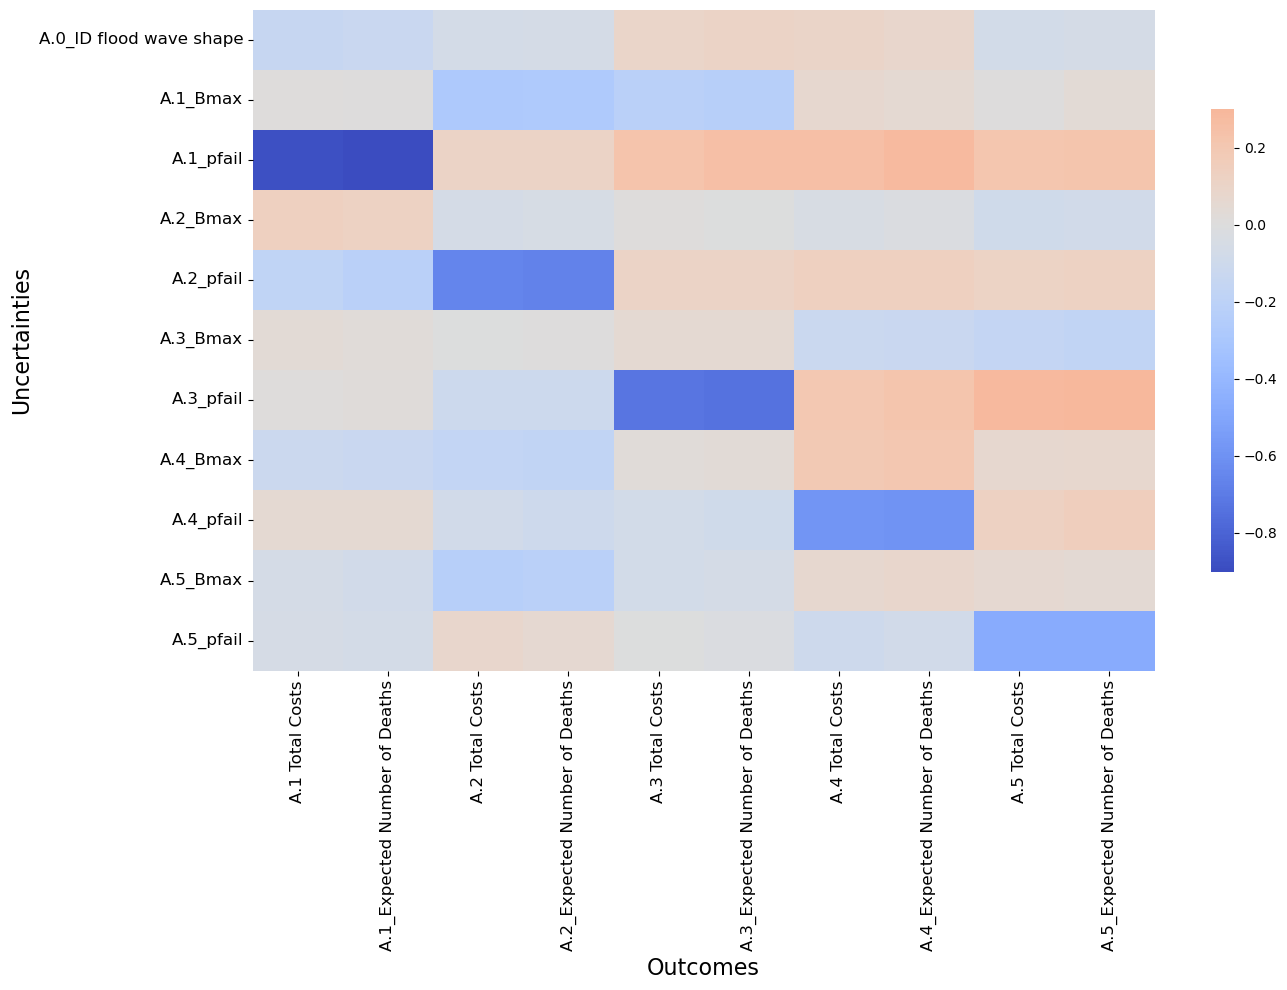

In [100]:
uncertainties_names = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.2_Bmax',
       'A.2_pfail', 'A.3_Bmax', 'A.3_pfail', 'A.4_Bmax', 'A.4_pfail',
       'A.5_Bmax', 'A.5_pfail']

df_uncertainties = df_experiments[uncertainties_names]
df_uncertainties_numeric = df_uncertainties.select_dtypes(include='number')


# Drop unwanted outcome columns from the DataFrame (not just from columns index)
df_selected_outcomes = df_outcomes.drop(columns=['policy', 'RfR Total Costs', 'Expected Evacuation Costs'])

# Combine with uncertainties
df_corr = pd.concat([
    df_uncertainties_numeric,
    df_selected_outcomes
], axis=1)

# Create correlation matrix
corr_matrix = df_corr.corr()

# Define which columns to extract
uncertainty_columns = df_uncertainties_numeric.columns
outcome_columns = df_selected_outcomes.columns

# Extract relevant submatrix
corr_submatrix = corr_matrix.loc[uncertainty_columns, outcome_columns]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_submatrix,
    #annot=True,
    #fmt=".2f",
    cmap='coolwarm',
    center=0,
    #linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)
#plt.title('Correlation Heatmap: Uncertainties vs Outcomes')
plt.xlabel('Outcomes', fontsize = 16)
plt.ylabel('Uncertainties', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Correlation heatmap policies vs outcomes

/Users/ninakerff/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


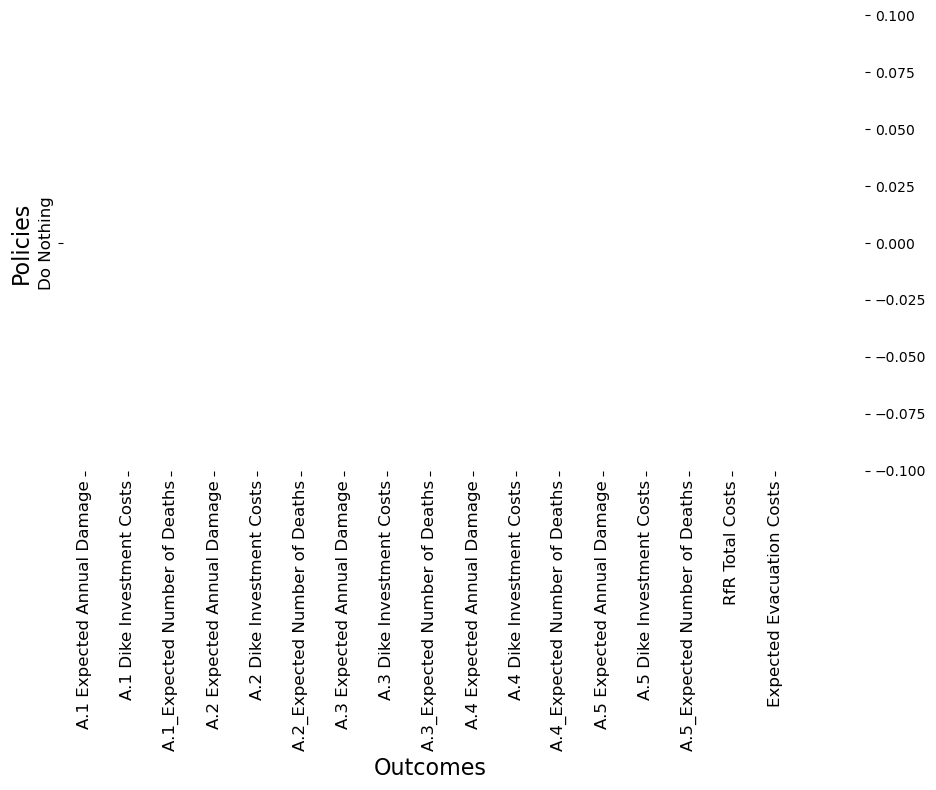

In [71]:
# Make a copy to work with
df = df_outcomes.copy()

# One-hot encode the 'policy' column
df_encoded = pd.get_dummies(df, columns=['policy'], drop_first=False)

# Rename policy columns to remove 'policy_' prefix
df_encoded.columns = [col.replace('policy_', '') for col in df_encoded.columns]

# Recalculate correlation
correlation_matrix = df_encoded.corr()

# Identify renamed policy and outcome columns
policy_names = df['policy'].unique().tolist()
policy_cols = [col for col in df_encoded.columns if col in policy_names]
outcome_cols = [col for col in df_encoded.columns if col not in policy_names]

# Subset correlation matrix
correlation_subset = correlation_matrix.loc[policy_cols, outcome_cols]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=False, cmap='coolwarm', center=0)
plt.xlabel("Outcomes", fontsize=16)
plt.ylabel("Policies", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

If correlation:

* +0.9 : Strong positive correlation – as uncertainty increases, outcome increases
* -0.9 : Strong negative correlation – as uncertainty increases, outcome decreases
* ~ 0: Little or no linear correlation 
